In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import ipas
import matplotlib.pyplot as plt
import numpy as np
import time
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import dask
from scipy import spatial 
from shapely.geometry import Point
from shapely.ops import nearest_points
import pandas as pd
from dask import dataframe as dd
import pickle

In [13]:
cluster = SLURMCluster(
queue='kratos',
walltime='04-23:00:00',
cores=1,
memory='20000MiB', #1 GiB = 1,024 MiB
processes=1)

cluster.scale(5)
client = Client(cluster)
print(client)

<Client: 'tcp://169.226.65.175:33941' processes=0 threads=0, memory=0 B>


In [16]:
client

Client Scheduler: tcp://169.226.65.175:33941 Dashboard: http://169.226.65.175:8787/status,Cluster Workers: 5 Cores: 5 Memory: 104.85 GB


In [17]:
def main():
    output = np.empty((len(phioarr),len(reqarr)),dtype=object)
    for phi in range(len(phioarr)):
        for r in range(len(reqarr)):
            output[phi,r] = dask.delayed(ipas.collect_clusters)(phioarr[phi], reqarr[r], nclusters, ncrystals,rand_orient)
            #ipas.collect_clusters(phioarr[phi], reqarr[r], nclusters, ncrystals,rand_orient)
#     delayeds = client.compute(delayeds)
#     output = client.gather(delayeds)
    return output

In [18]:
def compute():
    agg_as = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    agg_bs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    agg_cs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    phi2Ds = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    cplxs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    dds = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    major_ax_zs = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    depths = np.empty((len(phioarr),len(reqarr), nclusters, ncrystals-1))
    
    gather = client.compute([*output.tolist()])  #only parallelizing agg r bins
    gather = client.gather(gather)

    gather = np.array(gather)
    print(np.shape(gather))
    agg_as = gather[:,:,0]
    agg_bs = gather[:,:,1]
    print(agg_bs)
    agg_cs = gather[:,:,2]
    phi2Ds = gather[:,:,3]
    cplxs = gather[:,:,4] 
    dds = gather[:,:,5]
    major_ax_zs = gather[:,:,6]
    depths = gather[:,:,7]
    print('DONE!')
    return agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths

In [ ]:
if __name__ == '__main__':
    #phioarr=np.logspace(-2, 2, num=20, dtype=None)#just columns (0,2); plates (-2,0)
    phioarr = [0.5, 0.1, 1.0, 2.0, 10.]
    #reqarr = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    reqarr = [10]
    nclusters = 300         #changes how many aggregates per aspect ratio to consider
    ncrystals = 100
    rand_orient = False   #randomly orient the seed crystal and new crystal: uses first random orientation
    
    output = main()
    agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths = compute()

In [ ]:
#import bz2
#sfile = bz2.BZ2File('smallerfile', 'w')

with open('../instance_files/instance_iceagg_flat_r10_compareDunnavan', "ab") as f:
    pickle.dump((agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths), f)
    f.close()

### LOAD DATA BACK IN

In [3]:
f = open('../instance_files/instance_iceagg_flat_r10_compareDunnavan', 'rb')

agg_as, agg_bs, agg_cs, phi2Ds, cplxs, dds, major_ax_zs, depths = pickle.load(f)
f.close()

In [12]:
np.shape(cplxs) #phi, r, nclusters, ncrystals

(5, 1, 300, 99)

In [143]:
class IceClusterBatch():
    """A collection of IceCluster objects."""
    
    def __init__(self, nclusters, rxs, rys, rzs, phi2Ds, cplxs, dds, major_ax_zs, depths, numaspectratios, numrs):

        self.nclusters=nclusters
        self.rxs = rxs
        self.rys = rys
        self.rzs = rzs
        self.phi2Ds = phi2Ds
        self.cplxs = cplxs
        self.dds = dds
        self.major_ax_zs = major_ax_zs
        self.depths = depths
        self.numaspectratios = numaspectratios
        self.numrs = numrs

    def calculate_error(self, data, ch):
        mean = np.mean(data)
        std = np.std(data)
        shape = (mean/std)**2
        scale = (std**2)/mean
        shapech = mean/(self.numaspectratios*ch)

        pos_error = mean + std
        neg_error = mean - std

        min_data = min(data)
        max_data = max(data)

        return(pos_error, neg_error, min_data, max_data, mean)        


    def fit_distribution(self, data, normed = True, facecolor='navy', alpha=1.0, axes=None, **kwargs):

        """Model data by finding best fit distribution to data"""
        # Get histogram of original data

        #fig = plt.figure(figsize=(5,7))
        #ax = plt.subplot(131)

        data = np.array(data)
        data[np.isinf(data)] = min(data)
        data[np.isnan(data)] = min(data)
        if np.isinf(data).any():
            print('inf True')
        y, x = np.histogram(data, density=True)
        #print('x hist',x)
        xx = (x + np.roll(x, -1))[:-1] / 2.0
        
        params = st.gamma.fit(data)
        arg = params[:-2]       
        
        #pdf = self.make_pdf(distribution, gamma_params)
        pdf = st.gamma.pdf(xx, loc=params[-2], scale=params[-1], *arg)
        indmax = np.argmax(pdf)  #FIRST index where the highest prob occurs
        gammach_var = x[indmax] #characteristic of the distribution
        if axes is not None:
            n, bins, patches = plt.hist(data, bins=70, normed=True,
                                    color='navy',range=(min(data), max(data)),**kwargs)
            ax = plt.plot(xx, pdf, lw=5, color='darkorange')
            plt.show()

        return gammach_var

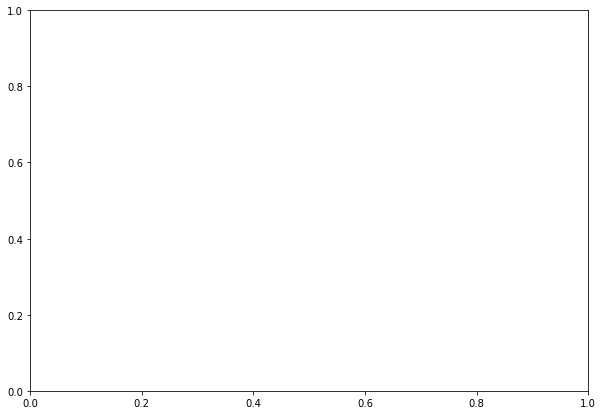

In [144]:
#find characteristic of gamma distribution
numaspectratios=len(agg_as[:,0,0])
numrs=len(agg_bs[0,:,0])
batch = IceClusterBatch(nclusters, agg_as, agg_bs, agg_cs, phi2Ds, \
                        cplxs, dds, major_ax_zs, depths, numaspectratios, numrs)

agg_cs_ch = np.empty((numaspectratios, numrs), dtype=np.float64) #major
agg_as_ch = np.empty((numaspectratios, numrs), dtype=np.float64) #minor
agg_as_mean = np.empty((numaspectratios, numrs), dtype=np.float64)
dds_ch = np.empty((numaspectratios, numrs), dtype=np.float64)
major_ax_zs_ch = np.empty((numaspectratios, numrs), dtype=np.float64)
major_ax_zs_mean = np.empty((numaspectratios, numrs), dtype=np.float64)
depths_ch = np.empty((numaspectratios, numrs), dtype=np.float64)

for i in range(numaspectratios):
    for r in range(numrs):
        #print(i,r)
        for c, data in enumerate([agg_cs, agg_as, dds, major_ax_zs, depths]):
            if c == 0:
                agg_cs_ch[i,r] = batch.fit_distribution(data[i,r,:])
            if c == 1:
                agg_as_ch[i,r] = batch.fit_distribution(data[i,r,:])
                _,_,_,_,agg_as_mean[i,r] = batch.calculate_error(data[i,r,:], agg_as_ch[i,r])
            if c == 2:
                dds_ch[i,r] = batch.fit_distribution(data[i,r,:])
            if c == 3:
                major_ax_zs_ch[i,r] = batch.fit_distribution(data[i,r,:])
                _,_,_,_,major_ax_zs_mean[i,r] = batch.calculate_error(data[i,r,:], agg_as_ch[i,r])
            if c == 4:
                depths_ch[i,r] = batch.fit_distribution(data[i,r,:])


In [145]:
#write to file for output as array:
with open("../lookup_tables/newformat_minorax_ellipsoid_flat_ch.dat","w") as file1:
    with open("../lookup_tables/newformat_majorax_ellipsoid_flat_ch.dat","w") as file2:
        with open("../lookup_tables/newformat_majorax_ellipsoid_flat_mean.dat","w") as file3:
            with open("../lookup_tables/newformat_dd_flat_ch.dat","w") as file4:
                with open ("../lookup_tables/newformat_majorax_ellipse_z_flat_ch.dat","w") as file5:
                    with open ("../lookup_tables/newformat_majorax_ellipse_z_flat_mean.dat","w") as file6:
                        with open ("../lookup_tables/newformat_depth_flat_ch.dat","w") as file7:
                        
                            file1.write('Ice-Ice collection for the flat orientation. \n'\
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                        'Order: phi, r, value \n')
                            
                            file2.write('Ice-Ice collection for the flat orientation. \n'
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                        'Order: phi, r, value \n')
                                
                            file3.write('Ice-Ice collection for the flat orientation. \n'
                                        'Mean value taken from the average across 300 aggregates. \n'\
                                        'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                        'Order: phi, r, value \n')
                                
                            file4.write('Ice-Ice collection for the flat orientation. \n'
                                        'Volume ratio of monomer (not 1.0) subtracted from volume ratio of agg (Vagg/Vellipse)\n'\
                                        'Characteristic value taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'
                                        'Order: phi, r, value \n')
                                
                            file5.write('Ice-Ice collection for the flat orientation. \n'\
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Major axis taken from a fit-ellipse (2D) in the z-orientation. \n'
                                        'Order: phi, r, value \n')
                                
                            file6.write('Ice-Ice collection for the flat orientation. \n'
                                        'Mean value taken from the average across 300 aggregates. \n'\
                                        'Major axis taken from a fit-ellipse (2D) in the z-orientation. \n'
                                        'Order: phi, r, value \n')
                                
                            file7.write('Ice-Ice collection for the flat orientation. \n'
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Depth measured as max z point - min z point. \n'
                                        'Order: phi, r, value \n')

                            for i in range(len(phioarr)):
                                for r in range(len(reqarr)):
                                    #print(i,r)
                                    file1.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_cs_ch[i,r]))
                                    file2.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_as_ch[i,r]))
                                    file3.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_as_mean[i,r]))
                                    file4.write('%.3f %.2f %.4f \n' %(phioarr[i], reqarr[r],  dds_ch[i,r]))
                                    file5.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  major_ax_zs_ch[i,r]))
                                    file6.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  major_ax_zs_mean[i,r]))
                                    file7.write('%.3f %.2f %.4f \n' %(phioarr[i], reqarr[r],  depths_ch[i,r]))

file1.close()
file2.close() 
file3.close()
file4.close()
file5.close()
file6.close()
file7.close()

In [136]:
#write to file for output as array:
with open("../lookup_tables/newformat_minorax_ellipsoid_rand_ch.dat","w") as file1:
    with open("../lookup_tables/newformat_majorax_ellipsoid_rand_ch.dat","w") as file2:
        with open("../lookup_tables/newformat_majorax_ellipsoid_rand_mean.dat","w") as file3:
            with open("../lookup_tables/newformat_dd_rand_ch.dat","w") as file4:
                with open ("../lookup_tables/newformat_majorax_ellipse_z_rand_ch.dat","w") as file5:
                    with open ("../lookup_tables/newformat_majorax_ellipse_z_rand_mean.dat","w") as file6:
                        with open ("../lookup_tables/newformat_depth_rand_ch.dat","w") as file7:
                        
                            file1.write('Ice-Ice collection for the random orientation. \n'\
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Minor axis taken as the smallest axis from the fit-ellipsoid \n'\
                                        'Order: phi, r, value \n')
                            
                            file2.write('Ice-Ice collection for the random orientation. \n'
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                        'Order: phi, r, value \n')
                                
                            file3.write('Ice-Ice collection for the random orientation. \n'
                                        'Mean value taken from the average across 300 aggregates. \n'\
                                        'Major axis taken as the largest axis from the fit-ellipsoid \n'
                                        'Order: phi, r, value \n')
                                
                            file4.write('Ice-Ice collection for the random orientation. \n'
                                        'Volume ratio of monomer (not 1.0) subtracted from volume ratio of agg (Vagg/Vellipse)\n'\
                                        'Characteristic value taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'
                                        'Order: phi, r, value \n')
                                
                            file5.write('Ice-Ice collection for the random orientation. \n'\
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Major axis taken from a fit-ellipse (2D) in the z-orientation. \n'
                                        'Order: phi, r, value \n')
                                
                            file6.write('Ice-Ice collection for the random orientation. \n'
                                        'Mean value taken from the average across 300 aggregates. \n'\
                                        'Major axis taken from a fit-ellipse (2D) in the z-orientation. \n'
                                        'Order: phi, r, value \n')
                                
                            file7.write('Ice-Ice collection for the random orientation. \n'
                                        'Characteristic values taken from the peak of a fit \n'\
                                        'gamma distribution from 300 aggregates. \n'\
                                        'Depth measured as max z point - min z point. \n'
                                        'Order: phi, r, value \n')

                            for i in range(len(phioarr)):
                                for r in range(len(reqarr)):
                                    #print(i,r)
                                    file1.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_cs_ch[i,r]))
                                    file2.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_as_ch[i,r]))
                                    file3.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  agg_as_mean[i,r]))
                                    file4.write('%.3f %.2f %.4f \n' %(phioarr[i], reqarr[r],  dds_ch[i,r]))
                                    file5.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  major_ax_zs_ch[i,r]))
                                    file6.write('%.3f %.2f %.2f \n' %(phioarr[i], reqarr[r],  major_ax_zs_mean[i,r]))
                                    file7.write('%.3f %.2f %.4f \n' %(phioarr[i], reqarr[r],  depths_ch[i,r]))

file1.close()
file2.close() 
file3.close()
file4.close()
file5.close()
file6.close()
file7.close()

In [146]:
df = pd.DataFrame(agg_cs_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_minorax_ellipsoid_flat_ch.dat', sep='\t')

df = pd.DataFrame(agg_as_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_majorax_ellipsoid_flat_ch.dat', sep='\t')

df = pd.DataFrame(agg_as_mean, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_majorax_ellipsoid_flat_mean.dat', sep='\t')

df = pd.DataFrame(dds_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_dd_rand_ch.dat', sep='\t')

df = pd.DataFrame(major_ax_zs_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_majorax_ellipse_z_flat_ch.dat', sep='\t')

df = pd.DataFrame(major_ax_zs_mean, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_majorax_ellipse_z_flat_mean.dat', sep='\t')

df = pd.DataFrame(depths_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_depth_flat_ch.dat', sep='\t')


In [137]:
df = pd.DataFrame(agg_cs_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_minorax_ellipsoid_rand_ch.dat', sep='\t')

df = pd.DataFrame(agg_as_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_majorax_ellipsoid_rand_ch.dat', sep='\t')

df = pd.DataFrame(agg_as_mean, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_majorax_ellipsoid_rand_mean.dat', sep='\t')

df = pd.DataFrame(dds_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_dd_rand_ch.dat', sep='\t')

df = pd.DataFrame(major_ax_zs_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_majorax_ellipse_z_rand_ch.dat', sep='\t')

df = pd.DataFrame(major_ax_zs_mean, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_majorax_ellipse_z_rand_mean.dat', sep='\t')

df = pd.DataFrame(depths_ch, index=phioarr, columns=reqarr)
df.to_csv('../lookup_tables/oldformat_depth_rand_ch.dat', sep='\t')
